In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from hyperopt import fmin, tpe, hp, Trials
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, GridSearchCV

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Modelización de impagos de préstamos**

Dentro del sector financiero existe un producto clave de comercialización: los **préstamos**, ya sean préstamos personales o hipotecarios.

Debido a la cuantía y el periodo de devolución de este tipo de productos, hace que cobre especial importancia **la propensión al impago**, para la gestión de provisiones y el plan de negocio.

Es por ello, que vamos a **crear un modelo estable y eficaz para la detección de préstamos que puedan llegar a impagarse**.



## Algoritmo
En este caso vamos a crear el modelo con **LightGBM** (*Light Gradient Boosting Machine*) es una biblioteca de aprendizaje automático de código abierto desarrollada por Microsoft que implementa algoritmos de gradient boosting. Está diseñada para ser eficiente y escalable, especialmente en conjuntos de datos grandes y dispersos.

El *boosting* es una técnica de aprendizaje supervisado que combina múltiples modelos para crear uno más estable.

LightGBM utiliza árboles de decisión como modelos base. Cada árbol se construye de manera secuencial, y cada nuevo árbol intenta corregir los errores del modelo combinado existente.

LightGBM se destaca por su eficiencia y escalabilidad. Utiliza un algoritmo de construcción de árboles llamado "Histogram-based Learning". Además, tiene un enfoque de paralelización y puede trabajar con grandes conjuntos de datos. Además, permite la regularización para evitar sobreajuste y ofrece una variedad de hiperparámetros que pueden ser ajustados para optimizar el rendimiento del modelo.


## Evaluación del modelo
La evaluación del desempeño de los clasificadores es relativamente compleja y depende de muchos factores, algunos de los cuales dependen del modelo. Con el fin de identificar el mejor modelo para nuestra tarea de clasificación, adopto diferentes métricas de evaluación que se resumen brevemente a continuación.

Para evitar el sobreentrenamiento, el rendimiento de nuestro modelo de clasificación se evalúa mediante validación cruzada. El conjunto de entrenamiento se divide aleatoriamente en $ N $ subconjuntos distintos llamados pliegues, luego el modelo se entrena y evalúa $ N $ veces mediante el uso de un pliegue diferente para la evaluación de un modelo que se entrena en los otros $ N-1 $ pliegues. Los resultados del procedimiento consisten en puntajes de evaluación de $ N $ para cada métrica que luego se promedian. Estos promedios se utilizan finalmente para comparar las diferentes técnicas consideradas en este estudio.


<a id='per'></a>
#### Precisión y recuperación
Precision-Recall es una métrica de rendimiento útil para evaluar un modelo en aquellos casos en que las clases están muy desequilibradas. En la recuperación de información, la precisión es una medida de la relevancia de los resultados, mientras que la recuperación es una medida de cuántos resultados verdaderamente relevantes se devuelven. Intuitivamente, la precisión es la capacidad del clasificador de no etiquetar como positiva una muestra negativa, y la recuperación es la capacidad del clasificador de encontrar todas las muestras positivas.

Un sistema con alta recuperación pero baja precisión devuelve muchas etiquetas que tienden a predecirse incorrectamente en comparación con las etiquetas de entrenamiento. Un sistema con alta precisión pero poca recuperación es todo lo contrario, arrojando muy pocos resultados, pero la mayoría de las etiquetas predichas son correctas en comparación con las etiquetas de entrenamiento. Un sistema ideal con alta precisión y alta recuperación devolverá muchos resultados, con muchos resultados etiquetados correctamente.

La precisión ($ P $) se define como el número de verdaderos positivos ($ T_ {p} $) sobre el número de verdaderos positivos más el número de falsos positivos ($ T_ {p} + F_ {p} $):

$P = \frac{T_{p}}{T_{p}+F_{p}}$  

La recuperación ($ R $) se define como el número de verdaderos positivos ($ T_ {p} $) sobre el número de verdaderos positivos más el número de falsos negativos ($ T_ {p} + F_ {n} $):

$R = \frac{T_{p}}{T_{p}+F_{n}}$

<a id='f1'></a>
#### Medida F1
A menudo es conveniente combinar la precisión y la recuperación en una única métrica llamada puntuación $ F_ {1} $, definida como una media armónica ponderada de la precisión y la recuperación:

$F_{1} = 2\times \frac{P \times R}{P+R}$

Mientras que la media regular trata todos los valores por igual, la media armónica da mucho más peso a los valores bajos. Como resultado, el clasificador solo obtendrá una puntuación F1 alta si tanto la memoria como la precisión son altas.
La puntuación $ F_ {1} $ favorece a los clasificadores que tienen una precisión y una recuperación similares. Esto no siempre es lo que desea: en algunos contextos, lo que más le importa es la precisión, y en otros contextos, realmente le importa el recuerdo.

Los **datos** disponibles son los préstamos dados por nuestra empresa en el que encontramos la siguiente información:


*   **Id_contrato:** Es el código identificador del préstamos
*  **fecha_alta_prestamo:** Fecha de alta del préstamo
*   **fecha_fin_prestamo:** Fecha teórica en la que finaliza el préstamo
*   **importe_prestamo:** Importe inicial concedido en el préstamo
*   **deuda_actual:** Deuda actual del préstamo
*   **valor_propiedad:** Valor de la propiedad inmobiliaria para el que se ha concedido la hipoteca o de la propiedad que avala el préstamo.
*   **tipo_interes:** La tipología de tipo de interés fijo/variable
*   **diferencial:** Diferencial para la hipoteca variable
*   **interes_inicial:** Valor del interés incial del préstamo en porcentaje
*   **objetivo_prestamo:** El objetivo con el ue se ha solicitado el préstamo. Si es para la compra de una vivienda o un préstamo personal.
*   **ocupacion:** Ocupación de la persona titular del contrato.
*  **años_trabajados:** Años trabajados de la persona titular del contrato.
*   **num_informes_cancelados:** Número de contratos anteriores ya cancelados con el titular del contrato.
*   **num_lineas_morosas_ant:** Número de contratos morosos que anteriormente ha tenido el titular del contrato.
*   **antigüedad_linea_mas_antigua:** Días de antigüedad del primer préstamo solicitado por el mismo titular del contrato.
*   **num_consultas_crediticias:** Número de solicitudes de préstamos por el titular del contrato.
*  **num_lineas_credito:** Número de contratos actuales del mismo titular del contrato.
*   **prestamo_incumplido:** Target. Si el contrato finalmente se ha impagado (1) o se ha pagado completamente sin incidentes (0).

## 1. Lectura de datos

In [2]:
#Indicamos la ubicación y nombre del fichero
archivo = 'DATOS_FLAMENGO.xlsx'

In [4]:
df = pd.read_excel(archivo)

## 2. Análisis de datos

In [5]:
#Previsualizamos los datos
df.head()

,Id_contrato,fecha_alta_prestamo,fecha_fin_prestamo,importe_prestamo,deuda_actual,valor_propiedad,tipo_interes,interes_inicial,diferencial,objetivo_prestamo,ocupacion,años_trabajados,num_informes_cancelados,num_lineas_morosas_ant,antigüedad_linea_mas_antigua,num_consultas_crediticias,num_lineas_credito,prestamo_incumplido
0,1000,2015-11-28,2034-04-24,218591,123993.972478,665773.000000,Fijo,4,NaN,Hipoteca,Profesor,35,1,1,NaN,0,0,0
1,1001,2002-01-26,2023-12-24,448716,2186.943764,NaN,Fijo,2,NaN,Préstamo personal,cuenta propia,0,2,2,3866.0,0,2,0
2,1002,2008-08-05,2035-10-19,613185,268823.858696,110135.287332,Fijo,3,NaN,Hipoteca,Directivo,11,2,1,987.0,0,4,0
3,1003,2008-12-02,2026-07-08,611839,91961.486541,265735.741504,Fijo,5,NaN,Hipoteca,Administrativo,7,1,0,432.0,1,5,0
4,1004,2000-04-25,2023-12-24,947415,4275.041652,751756.936006,Fijo,5,NaN,Hipoteca,Administrativo,34,0,0,3235.0,2,5,0


In [6]:
# Número de préstamos
print("Número de préstamos en cartera: ", df.count()["Id_contrato"])

Número de préstamos en cartera:  10500


In [7]:
#Revisamos el formato de los datos
df.dtypes

,0
Id_contrato,int64
fecha_alta_prestamo,datetime64[ns]
fecha_fin_prestamo,datetime64[ns]
importe_prestamo,int64
deuda_actual,float64
valor_propiedad,float64
tipo_interes,object
interes_inicial,int64
diferencial,float64
objetivo_prestamo,object


In [8]:
df.isnull().values.any() #Miramos si hay datos nulos en toda la tabla

True

In [9]:
#Dónde y cúantos nulos
print("Número de nulos en cada variable: ")
df.isnull().sum()

Número de nulos en cada variable: 


,0
Id_contrato,0
fecha_alta_prestamo,0
fecha_fin_prestamo,0
importe_prestamo,0
deuda_actual,0
valor_propiedad,62
tipo_interes,0
interes_inicial,0
diferencial,10291
objetivo_prestamo,0


In [10]:
# Porcentaje de impago entre los préstamos
pct_incumplimiento = np.round(df.prestamo_incumplido.mean()*100,2)
print(f"Porcentaje de préstamos con impago: {pct_incumplimiento}%")

Porcentaje de préstamos con impago: 1.5%


In [11]:
# Tipología de préstamos
df.groupby("objetivo_prestamo").count()["Id_contrato"]

,Id_contrato
objetivo_prestamo,
Hipoteca,10431
Préstamo personal,69


# 3. Identificamos y creamos las variables que queremos utilizar para crear el modelo

In [12]:
#Columnas del dataset
df.columns

Index(['Id_contrato', 'fecha_alta_prestamo', 'fecha_fin_prestamo',
       'importe_prestamo', 'deuda_actual', 'valor_propiedad', 'tipo_interes',
       'interes_inicial', 'diferencial', 'objetivo_prestamo', 'ocupacion',
       'años_trabajados', 'num_informes_cancelados', 'num_lineas_morosas_ant',
       'antigüedad_linea_mas_antigua', 'num_consultas_crediticias',
       'num_lineas_credito', 'prestamo_incumplido'],
      dtype='object')

Creamos nuevas variables:

Crea nuevas variables que puedan ayudar al modelo en la propensión al impago:

In [13]:
# Creamos el tiempo de vigencia del contrato
df["dias_vigencia"] = df["fecha_fin_prestamo"] - df["fecha_alta_prestamo"]
reference_date = pd.to_datetime("2023-12-01")


In [14]:
#Creo nuevas variables que puedan ayudar al modelo en la propensión al impago:

# Ratio de deuda a valor de la propiedad
df['ratio_deuda_valor'] = df['deuda_actual'] / df['valor_propiedad']

# Ratio de importe del préstamo a valor de la propiedad
df['ratio_importe_valor'] = df['importe_prestamo'] / df['valor_propiedad']

# Antigüedad del préstamo en meses
df['antiguedad_meses'] = (reference_date - pd.to_datetime(df['fecha_alta_prestamo'])).dt.days // 30

# Número de consultas crediticias por año trabajado
df['consultas_por_año_trabajado'] = df['num_consultas_crediticias'] / df['años_trabajados']

# Número de líneas morosas en relación al número de líneas de crédito totales
df['ratio_lineas_morosas_total'] = df['num_lineas_morosas_ant'] / df['num_lineas_credito']

#Utilizacion del credito a traves del tiempo
df['uso_credito_tiempo'] = df['deuda_actual'] / (df['importe_prestamo'] * df['antiguedad_meses']) *100

df['DynamicLTV'] = df['deuda_actual'] / df['valor_propiedad']

df['Total intereses'] = df['importe_prestamo'] * df['interes_inicial'] #Total Intereses pagados

#Estimamos el salario anual n un 3% en base a los años trabajados
annual_increase_percentage = 3  # Assume a 3% annual increase #HE DEDUCIDO QUE UNA PERSONA SUELE EMPEZAR CON UNOS 20 000€ AL AÑO Y QUE CADA AÑO SE INCREMENTA UN 3% QUE ES = 600€
df['estimated_salary'] = df['años_trabajados'].apply(
    lambda years: 20000 * (1 + (annual_increase_percentage / 100)) ** years
)

#Duda basada en ingresos (DTI)
df['DTI'] = df['deuda_actual'] / df['estimated_salary']




In [15]:
df.head()

,Id_contrato,fecha_alta_prestamo,fecha_fin_prestamo,importe_prestamo,deuda_actual,valor_propiedad,tipo_interes,interes_inicial,diferencial,objetivo_prestamo,...,ratio_deuda_valor,ratio_importe_valor,antiguedad_meses,consultas_por_año_trabajado,ratio_lineas_morosas_total,uso_credito_tiempo,DynamicLTV,Total intereses,estimated_salary,DTI
0,1000,2015-11-28,2034-04-24,218591,123993.972478,665773.000000,Fijo,4,NaN,Hipoteca,...,0.186241,0.328327,97,0.000000,inf,0.584785,0.186241,874364,56277.249087,2.203270
1,1001,2002-01-26,2023-12-24,448716,2186.943764,NaN,Fijo,2,NaN,Préstamo personal,...,NaN,NaN,265,NaN,1.00,0.001839,NaN,897432,20000.000000,0.109347
2,1002,2008-08-05,2035-10-19,613185,268823.858696,110135.287332,Fijo,3,NaN,Hipoteca,...,2.440851,5.567562,186,0.000000,0.25,0.235702,2.440851,1839555,27684.677414,9.710204
3,1003,2008-12-02,2026-07-08,611839,91961.486541,265735.741504,Fijo,5,NaN,Hipoteca,...,0.346064,2.302434,182,0.142857,0.00,0.082584,0.346064,3059195,24597.477308,3.738655
4,1004,2000-04-25,2023-12-24,947415,4275.041652,751756.936006,Fijo,5,NaN,Hipoteca,...,0.005687,1.260268,287,0.058824,0.00,0.001572,0.005687,4737075,54638.105910,0.078243


In [16]:
#La ponemos en el tipo necesario
df["ratio_deuda_valor"] = df["ratio_deuda_valor"].astype(float)
df["ratio_importe_valor"] = df["ratio_importe_valor"].astype(float)
df["antiguedad_meses"] = df["antiguedad_meses"].astype(float)
df["consultas_por_año_trabajado"] = df["consultas_por_año_trabajado"].astype(float)
df["ratio_lineas_morosas_total"] = df["ratio_lineas_morosas_total"].astype(float)
df["uso_credito_tiempo"] = df["uso_credito_tiempo"].astype(float)
df['DynamicLTV'] = df['DynamicLTV'].astype(float)
df['Total intereses'] = df['Total intereses'].astype(float)
df['estimated_salary'] = df['estimated_salary'].astype(float)
df['DTI'] = df['DTI'].astype(float)

In [17]:
#Revisamos el formato de los datos
df.dtypes

,0
Id_contrato,int64
fecha_alta_prestamo,datetime64[ns]
fecha_fin_prestamo,datetime64[ns]
importe_prestamo,int64
deuda_actual,float64
valor_propiedad,float64
tipo_interes,object
interes_inicial,int64
diferencial,float64
objetivo_prestamo,object


In [18]:
#Dónde y cúantos nulos
print("Número de nulos en cada variable: ")
df.isnull().sum()

Número de nulos en cada variable: 


,0
Id_contrato,0
fecha_alta_prestamo,0
fecha_fin_prestamo,0
importe_prestamo,0
deuda_actual,0
valor_propiedad,62
tipo_interes,0
interes_inicial,0
diferencial,10291
objetivo_prestamo,0


In [19]:
#He decido remplazar los valores nulos por las medianas de las variables que si voy a utilizar y tienen valores nulos con porcentajes altos po
columns_to_impute = ['valor_propiedad', 'ratio_deuda_valor', 'ratio_importe_valor', 'ratio_lineas_morosas_total', 'DynamicLTV']
for column in columns_to_impute:
    df[column] = df[column].fillna(df[column].median())

In [20]:
# Calculate the percentage of null values in each column
null_percentages = df.isnull().sum() / len(df) * 100

# Display the percentages
print(null_percentages)

Id_contrato                      0.000000
fecha_alta_prestamo              0.000000
fecha_fin_prestamo               0.000000
importe_prestamo                 0.000000
deuda_actual                     0.000000
valor_propiedad                  0.000000
tipo_interes                     0.000000
interes_inicial                  0.000000
diferencial                     98.009524
objetivo_prestamo                0.000000
ocupacion                        0.000000
años_trabajados                  0.000000
num_informes_cancelados          0.000000
num_lineas_morosas_ant           0.000000
antigüedad_linea_mas_antigua    24.066667
num_consultas_crediticias        0.000000
num_lineas_credito               0.000000
prestamo_incumplido              0.000000
dias_vigencia                    0.000000
ratio_deuda_valor                0.000000
ratio_importe_valor              0.000000
antiguedad_meses                 0.000000
consultas_por_año_trabajado      1.133333
ratio_lineas_morosas_total       0

Identificamos la lista de variables a utilizar:

In [21]:
df.columns

Index(['Id_contrato', 'fecha_alta_prestamo', 'fecha_fin_prestamo',
       'importe_prestamo', 'deuda_actual', 'valor_propiedad', 'tipo_interes',
       'interes_inicial', 'diferencial', 'objetivo_prestamo', 'ocupacion',
       'años_trabajados', 'num_informes_cancelados', 'num_lineas_morosas_ant',
       'antigüedad_linea_mas_antigua', 'num_consultas_crediticias',
       'num_lineas_credito', 'prestamo_incumplido', 'dias_vigencia',
       'ratio_deuda_valor', 'ratio_importe_valor', 'antiguedad_meses',
       'consultas_por_año_trabajado', 'ratio_lineas_morosas_total',
       'uso_credito_tiempo', 'DynamicLTV', 'Total intereses',
       'estimated_salary', 'DTI'],
      dtype='object')

In [22]:
 l_var_model = ['importe_prestamo', 'deuda_actual', 'valor_propiedad',
              'interes_inicial', 'objetivo_prestamo','num_lineas_morosas_ant',
              'DynamicLTV', 'num_consultas_crediticias',
              'num_lineas_credito', 'ratio_deuda_valor', 'ratio_importe_valor',
              'antiguedad_meses', 'consultas_por_año_trabajado',
              'ratio_lineas_morosas_total','uso_credito_tiempo', 'DTI', 'estimated_salary'] #ESCRIBE LA LISTA DE VARIABLES PARA TU MODELO #NO INCLUIR LA TARGET (que yo creo que es el prestamo_incumplido) N
                                                                           #NO SE SI HAY QUE METER SIMPLEMENTE LAS QUE HE CREADO ANTES O ESAS MAS LAS ANTIGUAS

# 4 . Separación de datos de train y test

Debemos identificar las variables que vamos a utilizar en el modelo:

In [23]:
#Renombramos la target
df.rename(columns={'prestamo_incumplido': 'target'}, inplace=True)

In [24]:
df.head()

,Id_contrato,fecha_alta_prestamo,fecha_fin_prestamo,importe_prestamo,deuda_actual,valor_propiedad,tipo_interes,interes_inicial,diferencial,objetivo_prestamo,...,ratio_deuda_valor,ratio_importe_valor,antiguedad_meses,consultas_por_año_trabajado,ratio_lineas_morosas_total,uso_credito_tiempo,DynamicLTV,Total intereses,estimated_salary,DTI
0,1000,2015-11-28,2034-04-24,218591,123993.972478,665773.000000,Fijo,4,NaN,Hipoteca,...,0.186241,0.328327,97.0,0.000000,inf,0.584785,0.186241,874364.0,56277.249087,2.203270
1,1001,2002-01-26,2023-12-24,448716,2186.943764,212943.312207,Fijo,2,NaN,Préstamo personal,...,0.750728,1.901010,265.0,NaN,1.00,0.001839,0.750728,897432.0,20000.000000,0.109347
2,1002,2008-08-05,2035-10-19,613185,268823.858696,110135.287332,Fijo,3,NaN,Hipoteca,...,2.440851,5.567562,186.0,0.000000,0.25,0.235702,2.440851,1839555.0,27684.677414,9.710204
3,1003,2008-12-02,2026-07-08,611839,91961.486541,265735.741504,Fijo,5,NaN,Hipoteca,...,0.346064,2.302434,182.0,0.142857,0.00,0.082584,0.346064,3059195.0,24597.477308,3.738655
4,1004,2000-04-25,2023-12-24,947415,4275.041652,751756.936006,Fijo,5,NaN,Hipoteca,...,0.005687,1.260268,287.0,0.058824,0.00,0.001572,0.005687,4737075.0,54638.105910,0.078243


In [25]:
#Indica el porcentaje de test y tu semilla
tamanio_test = 0.20
semilla = 269

In [26]:
# Limpieza de datos: Convertir columnas a tipo string y luego a category
for col in ['tipo_interes', 'objetivo_prestamo', 'ocupacion']:
    df[col] = df[col].astype('category')

df.dtypes

,0
Id_contrato,int64
fecha_alta_prestamo,datetime64[ns]
fecha_fin_prestamo,datetime64[ns]
importe_prestamo,int64
deuda_actual,float64
valor_propiedad,float64
tipo_interes,category
interes_inicial,int64
diferencial,float64
objetivo_prestamo,category


In [27]:
X = df[[*l_var_model]]
y = df['target']


In [28]:
# Separar en conjuntos de entrenamiento, validación y testeo (por ejemplo, 80% para entrenamiento, 20% para prueba)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tamanio_test, random_state=semilla)

# Imprimir las formas de los conjuntos para verificar
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)

print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (8400, 17)
Forma de X_test: (2100, 17)
Forma de y_train: (8400,)
Forma de y_test: (2100,)


Comprobamos que se han hecho correctamente las muestras y se mantiene el porcentaje de incumplimiento del Dataset original

In [29]:
 # Porcentaje de impago entre los préstamos

# Calculamos el porcentaje de impago entre los préstamos en el conjunto de entrenamiento.
percentage_impago_train = y_train.mean() * 100

# Imprime el resultado
print(f"Percentage of loan defaults in the training set: {percentage_impago_train:.2f}%")



Percentage of loan defaults in the training set: 1.50%


In [30]:
# Porcentaje de impago entre los préstamos en TEST

# Calculamos el porcentaje de impago entre los préstamos en el conjunto de prueba.
percentage_impago_test = y_test.mean() * 100

# Imprime el resultado
print(f"Porcentaje de impago entre los préstamos en TEST: {percentage_impago_test:.2f}%")

Porcentaje de impago entre los préstamos en TEST: 1.48%


## 5. Preparamos los datos para la creación del modelo

El algoritmo LGBM classifier necesita una serie de requisitos:

- Lista de variables categóricas

Debemos identificar las variables categóricas y ponerlas en el formato correcto:

In [31]:
l_var_categoricas = df.select_dtypes(include=['object']).columns.tolist()

In [32]:
l_var_categoricas

[]

## 6.Creamos el modelo

In [33]:
# Crear un clasificador LightGBM
lgbm = lgb.LGBMClassifier()

# Entrenar el modelo
lgbm_fit = lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 126, number of negative: 8274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2462
[LightGBM] [Info] Number of data points in the train set: 8400, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015000 -> initscore=-4.184591
[LightGBM] [Info] Start training from score -4.184591


Vemos la importancia de variables:

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

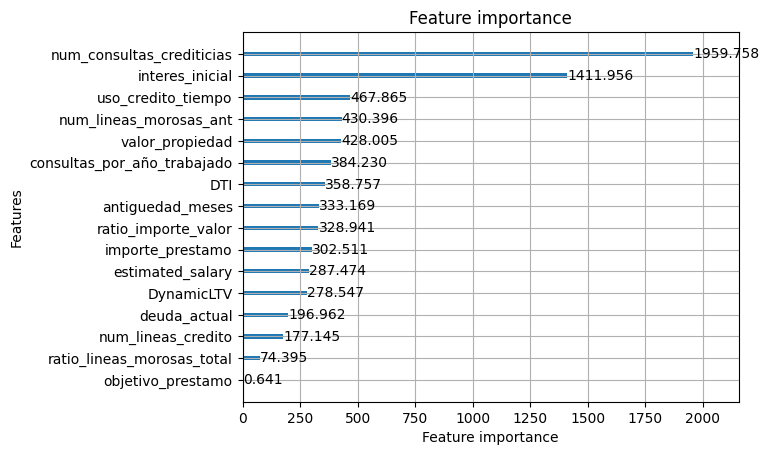

In [34]:
lgb.plot_importance(lgbm_fit, importance_type="gain")

# 7. Evaluamos el modelo

In [35]:
#Hay que tener en cuenta en el modelo LightGBM que el numero de categorias dentro de las variables que hemos cambiado de object a category son las mismas ya que sino, no funciona.

# Get categorical columns for both DataFrames
categorical_cols_train = X_train.select_dtypes(include=['category']).columns
categorical_cols_test = X_test.select_dtypes(include=['category']).columns

# Check categories for X_train
print("Categorical features and their number of categories in X_train:")
for col in categorical_cols_train:
    num_categories = len(X_train[col].cat.categories)  # or X_train[col].nunique()
    print(f"- {col}: {num_categories} categories")

# Check categories for X_test
print("\nCategorical features and their number of categories in X_test:")
for col in categorical_cols_test:
    num_categories = len(X_test[col].cat.categories)  # or X_test[col].nunique()
    print(f"- {col}: {num_categories} categories")

Categorical features and their number of categories in X_train:
- objetivo_prestamo: 2 categories

Categorical features and their number of categories in X_test:
- objetivo_prestamo: 2 categories


In [36]:
print(X_test.dtypes)

importe_prestamo                  int64
deuda_actual                    float64
valor_propiedad                 float64
interes_inicial                   int64
objetivo_prestamo              category
num_lineas_morosas_ant            int64
DynamicLTV                      float64
num_consultas_crediticias         int64
num_lineas_credito                int64
ratio_deuda_valor               float64
ratio_importe_valor             float64
antiguedad_meses                float64
consultas_por_año_trabajado     float64
ratio_lineas_morosas_total      float64
uso_credito_tiempo              float64
DTI                             float64
estimated_salary                float64
dtype: object


In [37]:
# Assuming 'tipo_interes', 'objetivo_prestamo', 'ocupacion' are categorical
categorical_features = ['objetivo_prestamo']

for feature in categorical_features:
    # Get categories from X_train
    categories = X_train[feature].cat.categories

    # Convert to 'category' and set categories in X_test
    X_test[feature] = pd.Categorical(X_test[feature], categories=categories)

In [38]:
# Obtener las probabilidades predichas en los conjuntos
y_train_pred_proba = lgbm_fit.predict_proba(X_train)[:, 1]
y_test_pred_proba = lgbm_fit.predict_proba(X_test)[:, 1]

In [39]:
# Calcular AUC en los conjuntos
auc_train = np.round(roc_auc_score(y_train, y_train_pred_proba),3)
auc_test = np.round(roc_auc_score(y_test, y_test_pred_proba),3)

print(f'AUC en conjunto de entrenamiento: {auc_train}')
print(f'AUC en conjunto de test: {auc_test}')

print(f'Podemos ver un claro overfitting en el conjunto de entrenamiento, esto se regulara a la hora de optimizar los hiperparametros')

AUC en conjunto de entrenamiento: 1.0
AUC en conjunto de test: 0.947
Podemos ver un claro overfitting en el conjunto de entrenamiento, esto se regulara a la hora de optimizar los hiperparametros


In [40]:
# Calcular la precisión promedio en los conjuntos
ap_train = np.round(average_precision_score(y_train, y_train_pred_proba),2)
ap_test = np.round(average_precision_score(y_test, y_test_pred_proba),2)

print(f'Average Precision en conjunto de entrenamiento: {ap_train}')
print(f'Average Precision en conjunto de test: {ap_test}')
#AP en conjutno de entrenamiento 1.0 = Indicio de OVERFITTING

Average Precision en conjunto de entrenamiento: 1.0
Average Precision en conjunto de test: 0.6


In [41]:
# Obtener las etiquetas predichas en los conjuntos
y_train_pred = lgbm_fit.predict(X_train)
y_test_pred = lgbm_fit.predict(X_test)

# Calcular el F1-score en los conjuntos
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)


print(f'F1-score en conjunto de entrenamiento: {f1_train}')
print(f'F1-score en conjunto de validación: {f1_test}')


F1-score en conjunto de entrenamiento: 1.0
F1-score en conjunto de validación: 0.6923076923076923


In [42]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)

print('Matriz de Confusión en conjunto de prueba:')
print(conf_matrix)

# Calculamos las métricas en test
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)


print(f'Accuracy en conjunto de test: {accuracy_test}')
print(f'F1-score en conjunto de test: {f1_test}')
print(f'Precision en conjunto de test: {precision_test}')
print(f'Recall en conjunto de test: {recall_test}')


Matriz de Confusión en conjunto de prueba:
[[2066    3]
 [  13   18]]
Accuracy en conjunto de test: 0.9923809523809524
F1-score en conjunto de test: 0.6923076923076923
Precision en conjunto de test: 0.8571428571428571
Recall en conjunto de test: 0.5806451612903226


Optimizamos hiperparámetros y comparamos:

In [43]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7, 12],
    'min_data_in_leaf': [10, 30, 50, 80],
}


In [44]:
# Inicializar GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='f1')

# Ajustar el modelo a los datos de entrenamiento
gs_fit = grid_search.fit(X_train, y_train )

# Imprimir los mejores parámetros y el rendimiento asociado
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor precisión en conjunto de entrenamiento:", grid_search.best_score_)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [46]:
# Evaluar el modelo en el conjunto de prueba
y_pred = grid_search.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

print('Matriz de Confusión en conjunto de prueba:')
print(conf_matrix)

# Calculamos las métricas en test
accuracy_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)


print(f'Accuracy en conjunto de test: {accuracy_test}')
print(f'F1-score en conjunto de test: {f1_test}')
print(f'Precision en conjunto de test: {precision_test}')
print(f'Recall en conjunto de test: {recall_test}')

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Matriz de Confusión en conjunto de prueba:
[[2066    3]
 [  15   16]]
Accuracy en conjunto de test: 0.9914285714285714
F1-score en conjunto de test: 0.64
Precision en conjunto de test: 0.8421052631578947
Recall en conjunto de test: 0.5161290322580645


# Conclusiones

In [ ]:
# ESCRIBE AQUÍ TUS CONCLUSIONES

En lineas generales el modelo demuestra una alta exactitud. No obstante, el Recall (R) en el conjunto de test sigue siendo muy bajo a pesar de todos los cambios que he intentado hacer para tenerlo mas alto. He aplicado variables financieras como "prediccion de salario" o incluso la deuda basada en los ingresos (DIT). También, he limpiado los datos remplazando los valores nulos por la mediana ya que esta es mas "robusta" a valores atipicos la cual preserva la distribucion original en comparacion con la media por ejemplo. Entonces ya es algo que se necesitaria un analisis mas profundo. Ya comparando los resultados del model de prediccion de impagos antes y despues de optimizar los parametros este no ha cambiado mucho, de hecho baja el cual es atipico.

En los parametros después de la optimizacion hay de hecho una disminucion ligera en el recall que nosotros lo tenemos explicado arriba como "La Recuperacion" la cual decrece de 0,58 a 0,51. Esto puede ser debido a que al optimizar los parámetros, es posible que el modelo se haya ajustado demasiado a los datos de entrenamiento, lo que puede llevar a un menor rendimiento en datos nuevos. Incluso esto puede ser debido a un desequilibrio de las clases ya que si tenemos una mas frecuente que la otra el modelo puede estar sesgado hacia la clase mayoritaria. Sin embargo, esta metrica es clave y mas para este caso financiero ya que mide la capacidad de un modelo para identificar todos los casos REALES de una clase especifica.

En este contexto, el recall indica la proporcion de prestamos que realmente incumplieron y que el modelo identifico corrctamente como tales como esta explicado arriba del todo. Recall = Verdaderos Positivos / (Verdaderos positivos + Falsos Negativos). Este dato puede ser preocupante para las entidades financieras ya que en este caso solo esta identificando correctamente el 51% de los prestamos que realmente incumpliran. El 49% restante de los impagos reales seran pasados por alto por el modelo, lo que podria generar perdidas financieras. Un F1 score de 0.64 indica que el modelo tiene un rendimiento moderado en la tarea de clasificación. No es un valor bajo como el recall pero si tiene margen de mejora.

En resumen, el modelo muestra una alta precision (0,84) en la prediccion de los impagos, lo que significa que cuando este predice un impago, es muy probable que sea correcto. Sin embargo, tiene un recall muy bajo, lo que significa que esta pasando por alto una parte significativa de los impagos reales. El F1 score se encuentra en un valor moderado, reflejando esta situacion. Un sistema con alta precisión pero poca recuperación (recall) es todo lo contrario, arrojando muy pocos resultados, pero la mayoría de las etiquetas predichas son correctas en comparación con las etiquetas de entrenamiento. Un sistema ideal con alta precisión y alta recuperación devolverá muchos resultados, con muchos resultados etiquetados correctamente.

Algunas estrategias que me parecen interesantes para aumentar el recall del modelo que estan en nuestra mano son las siguientes:
1. **Manejar el desequilibrio de Clases:**
En este caso si nuestro dataset tiene muchos mas prestamos sin impago que con impago, el modelo podria estar sesgado hacia la clase mayoritaria. Para poder abordar este problema podriamos aplicar tecnicas como Oversampling, Undersampling o pesos de clase. Incluso al principio del modelo podemos ver como hay mucho mas prestamos por Hipoteca que por Prestamo personal, tal vez este sea un indicio de oversampling.
2. **Ajustar el umbral de decisión:** El modelo predice la probabilidad de impago y, por defecto, utiliza un umbral de 0.5 para clasificar un préstamo como impago o no. Podemos ajustar este umbral para favorecer el recall, sin embargo no estoy muy seguro ya que no hemos tocado esto en clase. Reducir el umbral aumentará el recall, pero también podría disminuir la precisión.
3. **Probar otros algoritmos:** LightGBM es un buen algoritmo pero podriamos probar con Random Forest, XGBoost o incluso redes neuronales

